# Cats & Dogs Classification with Pytorch from Scratch
![](https://storage.googleapis.com/kaggle-datasets-images/23777/30378/63f920316cce877d41395932d0d089d0/dataset-cover.jpg?t=2018-04-27-04-56-03)
This notebook walks you through how to build a CNN model and predict data. 

Overview:
- 1. Loading the dataset
- 2. Understanding the dataset
- 3. Transforming data¶
- 4. Loading image data
- 5. Model building with data augmentation
- 6. Make a prediction

Let's start by looking at the version of the torch.

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.11.0'

Let's check whether Cuda exists or not.

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Loading the Dataset

In [3]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
image_path = "/kaggle/input/cat-and-dog"
walk_through_dir(image_path)

There are 2 directories and 0 images in '/kaggle/input/cat-and-dog'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/test_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/test_set/test_set'.
There are 0 directories and 1013 images in '/kaggle/input/cat-and-dog/test_set/test_set/dogs'.
There are 0 directories and 1012 images in '/kaggle/input/cat-and-dog/test_set/test_set/cats'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/training_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/training_set/training_set'.
There are 0 directories and 4006 images in '/kaggle/input/cat-and-dog/training_set/training_set/dogs'.
There are 0 directories and 4001 images in '/kaggle/input/cat-and-dog/training_set/training_set/cats'.


In [5]:
# Setup train and testing paths 
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"
train_dir, test_dir

('/kaggle/input/cat-and-dog/training_set/training_set',
 '/kaggle/input/cat-and-dog/test_set/test_set')

# 2. Understanding the Dataset

Random image path: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4202.jpg
Image class: cats
Image height: 217
Image width: 179


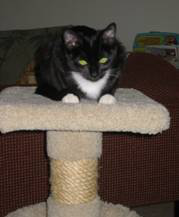

In [6]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

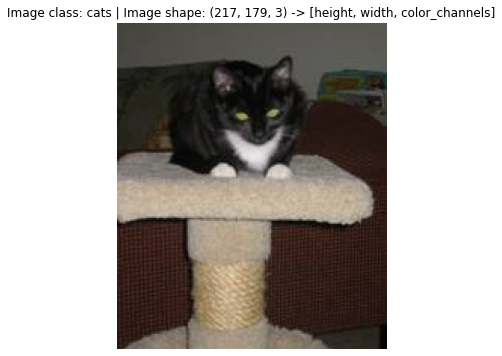

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming Data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Data Transformation

In [9]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

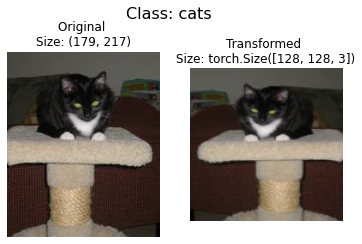

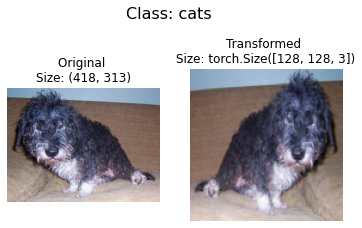

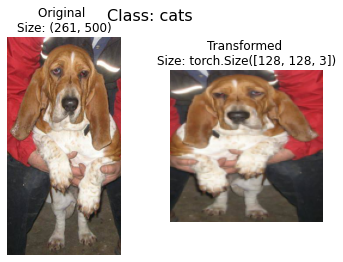

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

# 4. Loading Image Data

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: /kaggle/input/cat-and-dog/training_set/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: /kaggle/input/cat-and-dog/test_set/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['cats', 'dogs']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'cats': 0, 'dogs': 1}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(8005, 2023)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7843, 0.7804, 0.6196,  ..., 0.1608, 0.1608, 0.1569],
         [0.7843, 0.7529, 0.6157,  ..., 0.1490, 0.1490, 0.1529],
         [0.7882, 0.7373, 0.6118,  ..., 0.1333, 0.1333, 0.1490],
         ...,
         [0.1765, 0.2627, 0.2353,  ..., 0.0784, 0.0784, 0.0863],
         [0.1765, 0.1804, 0.2157,  ..., 0.0863, 0.0902, 0.1098],
         [0.1804, 0.1804, 0.2431,  ..., 0.0863, 0.0902, 0.1176]],

        [[0.7765, 0.7686, 0.6235,  ..., 0.1725, 0.1765, 0.1765],
         [0.7686, 0.7373, 0.6118,  ..., 0.1608, 0.1647, 0.1725],
         [0.7608, 0.7176, 0.6039,  ..., 0.1451, 0.1490, 0.1686],
         ...,
         [0.1255, 0.2078, 0.1765,  ..., 0.0706, 0.0706, 0.0784],
         [0.1255, 0.1255, 0.1569,  ..., 0.0784, 0.0824, 0.1020],
         [0.1333, 0.1255, 0.1804,  ..., 0.0784, 0.0824, 0.1098]],

        [[0.6353, 0.6667, 0.5804,  ..., 0.1922, 0.1804, 0.1608],
         [0.6431, 0.6431, 0.5765,  ..., 0.1804, 0.1686, 0.1569],
         [0.6510, 0.6353, 0.5843,  ..., 0.16

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


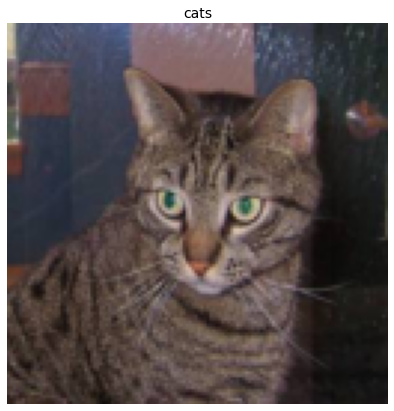

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Turn loaded images into DataLoader's

In [18]:
# Turn train and test Datasets into DataLoaders
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f214c511510>,
 <torch.utils.data.dataloader.DataLoader at 0x7f214c511650>)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Model Building with Data Augmentation

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

## 5.1 Creating transforms and loading data

In [20]:
# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
     transforms.Normalize(
         [0.485, 0.456,0.406],  
         [0.229, 0.224, 0.225])  
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
         [0.485, 0.456,0.406],  
         [0.229, 0.224, 0.225])  
])

In [21]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /kaggle/input/cat-and-dog/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /kaggle/input/cat-and-dog/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [22]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7f214c7f1a50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f214c576f10>)

## 5.2 Creating CNN Image Classifier

In [23]:
class CNNImageClassifier(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(hidden_units),
          nn.MaxPool2d(2)
          ) 
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(hidden_units),
          nn.MaxPool2d(2)
          ) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model = CNNImageClassifier(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=128, 
                  output_shape=len(train_data.classes)).to(device)
model

CNNImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=2, bias=True)
  )
)

## 5.3 Try a forward pass on a single image (to test the model)

In [24]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[0.0232, 0.0068]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5041, 0.4959]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


## 5.4 Understanding the model

In [25]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
CNNImageClassifier                       [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [1, 128, 128, 128]        3,584
│    └─ReLU: 2-2                         [1, 128, 128, 128]        --
│    └─BatchNorm2d: 2-3                  [1, 128, 128, 128]        256
│    └─MaxPool2d: 2-4                    [1, 128, 64, 64]          --
├─Sequential: 1-2                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─BatchNorm2d: 2-7                  [1, 128, 64, 64]          256
│    └─MaxPool2d: 2-8                    [1, 128, 32, 32]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          (recursive)
│    └─Conv2d: 2-9                       [1, 128, 32, 32]         

## 5.5 Create train & test loop functions

In [26]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 5.6 Creating a train() function to combine train_step() and test_step()

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5.7 Train and Evaluate Model

In [29]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

model = CNNImageClassifier(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=128, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7292 | train_acc: 0.6032 | test_loss: 0.7845 | test_acc: 0.6068
Epoch: 2 | train_loss: 0.6685 | train_acc: 0.6442 | test_loss: 0.8098 | test_acc: 0.6136
Epoch: 3 | train_loss: 0.6247 | train_acc: 0.6825 | test_loss: 0.5935 | test_acc: 0.7167
Epoch: 4 | train_loss: 0.5836 | train_acc: 0.7069 | test_loss: 0.9120 | test_acc: 0.6309
Epoch: 5 | train_loss: 0.5362 | train_acc: 0.7302 | test_loss: 0.9026 | test_acc: 0.6348
Epoch: 6 | train_loss: 0.5111 | train_acc: 0.7549 | test_loss: 0.6275 | test_acc: 0.7176
Epoch: 7 | train_loss: 0.4791 | train_acc: 0.7754 | test_loss: 0.5579 | test_acc: 0.7616
Epoch: 8 | train_loss: 0.4634 | train_acc: 0.7786 | test_loss: 0.4591 | test_acc: 0.7953
Epoch: 9 | train_loss: 0.4171 | train_acc: 0.8047 | test_loss: 0.4188 | test_acc: 0.8209
Epoch: 10 | train_loss: 0.4096 | train_acc: 0.8144 | test_loss: 0.4352 | test_acc: 0.8022
Epoch: 11 | train_loss: 0.3882 | train_acc: 0.8212 | test_loss: 0.3586 | test_acc: 0.8390
Epoch: 12 | train_l

## 5.8 Plot the loss curves of Model

In [30]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [31]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

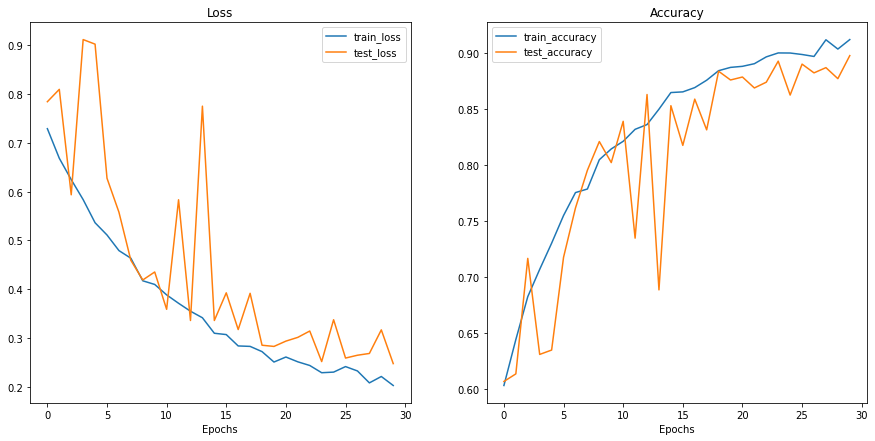

In [32]:
plot_loss_curves(model_results)

# 6. Make a prediction on a custom image

In [33]:
# Setup custom image path
custom_image_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg"

In [34]:
import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4941, 0.3059, 0.3059,  ..., 0.5490, 0.5412, 0.5451],
         [0.5333, 0.3451, 0.3059,  ..., 0.5490, 0.5451, 0.5490],
         [0.5686, 0.3961, 0.2980,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.6157, 0.6039, 0.6314,  ..., 0.6392, 0.6157, 0.5961],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6157, 0.5882],
         [0.6157, 0.6039, 0.6314,  ..., 0.6471, 0.6118, 0.5804]],

        [[0.4314, 0.2431, 0.2392,  ..., 0.5490, 0.5412, 0.5451],
         [0.4863, 0.2941, 0.2549,  ..., 0.5490, 0.5451, 0.5490],
         [0.5412, 0.3686, 0.2706,  ..., 0.5490, 0.5451, 0.5490],
         ...,
         [0.4784, 0.4667, 0.4941,  ..., 0.5608, 0.5373, 0.5176],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5373, 0.5098],
         [0.4784, 0.4667, 0.4941,  ..., 0.5686, 0.5333, 0.5020]],

        [[0.3333, 0.1529, 0.1686,  ..., 0.5804, 0.5725, 0.5765],
         [0.4000, 0.2196, 0.1882,  ..., 0.5804, 0.5765, 0.5804],
         [0.4667, 0.2980, 0.2078,  ..

In [35]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 499, 421])
New shape: torch.Size([3, 128, 128])


In [36]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 128, 128])
Unsqueezed custom image shape: torch.Size([1, 3, 128, 128])


In [37]:
# let's take a look at our model's predictions.
custom_image_pred

tensor([[-0.0137, -0.3946]], device='cuda:0')

In [38]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.0137, -0.3946]], device='cuda:0')
Prediction probabilities: tensor([[0.5941, 0.4059]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [39]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'cats'

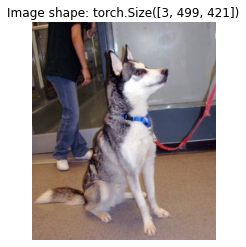

In [40]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

📌 If you like this notebook, don't forget to upvote it 😊
Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎